Importing modules

In [245]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1- Gathering Data
### First will be gather the given csv

In [180]:
tweets = pd.read_csv('twitter-archive-enhanced-2.csv')

Now, tweet image predictions will be gather

In [181]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
breeds = pd.read_csv(url, sep='\t')

Finally, data from API will be gather. Due the complications to get all the information with a free API account, it will be used the .txt, this will be gathered using request and then writing the file tweet-son.zip

In [182]:
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)
with open('tweet_json.txt','w') as file:
    file.write(response.content.decode("utf-8"))


In [183]:
tw_extend = pd.read_json('tweet_json.txt', lines=True)

# 2. Assesing Data

In [184]:
tweets.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [185]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [186]:
#Quantity of rows with Name equal to None
tweets[tweets['name'] == 'None'].shape

(745, 17)

In [187]:
# verify tweets id are uniques
len(tweets['tweet_id'].unique())

2356

In [188]:
tweets [pd.notna(tweets['retweeted_status_id']) == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [189]:
tweets['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [190]:
tweets['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [191]:
tweets['source'][1]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [192]:
len(tweets.loc[tweets['rating_numerator']>20])

24

In [193]:
tweets.loc[tweets['rating_numerator']<10]['text'].iloc[10]

"RT @dog_rates: Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10 https://…"

In [194]:
tweets[['doggo','floofer','pupper','puppo']].value_counts()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                pupper  None      245
doggo  None     None    None       83
None   None     None    puppo      29
doggo  None     pupper  None       12
None   floofer  None    None        9
doggo  floofer  None    None        1
       None     None    puppo       1
dtype: int64

In [195]:
breeds.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [196]:
breeds.shape

(2075, 12)

In [197]:
breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [198]:
# verify tweets id are uniques
len(breeds['tweet_id'].unique())

2075

In [199]:
breeds['p1'].value_counts()

golden_retriever       150
Labrador_retriever     100
Pembroke                89
Chihuahua               83
pug                     57
                      ... 
lynx                     1
basketball               1
pedestal                 1
teapot                   1
African_hunting_dog      1
Name: p1, Length: 378, dtype: int64

In [200]:
tw_extend.head(20)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
5,2017-07-29 00:08:17+00:00,891087950875897856,891087950875897856,Here we have a majestic great white breaching ...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,20562,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
6,2017-07-28 16:27:12+00:00,890971913173991426,890971913173991424,Meet Jax. He enjoys ice cream so much he gets ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,12041,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
7,2017-07-28 00:22:40+00:00,890729181411237888,890729181411237888,When you watch your owner call another dog a g...,False,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,56848,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
8,2017-07-27 16:25:51+00:00,890609185150312448,890609185150312448,This is Zoey. She doesn't want to be one of th...,False,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,28226,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
9,2017-07-26 15:59:51+00:00,890240255349198849,890240255349198848,This is Cassie. She is a college pup. Studying...,False,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,32467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [201]:
tw_extend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

#### Quality
##### `tweets` table
- tweet_id id integer not a string
- timestamp colum is type object should be datetime
- retweeted_status_timestamp is type object should be datetime
- Not all names where extracted from text (745 missing) and "a" and others words are taken like a Name.
- Some tweets are RT
- url tags in Source


##### `breeds` table
- tweet_id id integer not a string


##### `tw_extend` table
- tweet_id id integer not a string
- id and id_str has differents values, must be the same


#### Tidiness
- Combine Dog Stages in one column
- Merge `tw_extend`, `breeds` and `tweets` in one dataframe




# Clean


In [202]:
breeds_clean = breeds.copy()
tweets_clean = tweets.copy()
extend_clean = tw_extend.copy()

### `tweets` ,  `breeds`  : tweet_id id integer not a string

Define

Change the type to str

Code

In [203]:
tweets_clean['tweet_id'] = tweets_clean.tweet_id.astype(str)
breeds_clean['tweet_id'] = breeds_clean.tweet_id.astype(str)

Test

In [204]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [205]:
breeds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### `tweets`  : timestamp and retweeted_status_timestamp  type object

Define

First, its necessary to delete '+000'.Then, transform to time

Code

In [206]:
tweets_clean['timestamp'] = tweets_clean['timestamp'].str.replace('+', '')
tweets_clean['timestamp'] = tweets_clean['timestamp'].str.replace('0000', '')

In [207]:
tweets_clean['timestamp'] = pd.to_datetime(tweets_clean['timestamp'])
tweets_clean['retweeted_status_timestamp'] = pd.to_datetime(tweets_clean['retweeted_status_timestamp'])

Test

In [208]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns]     
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### `tweets`  : Not all names where extracted from text (745 missing)

Define:
    
To get the name, will be identify the string 'This is' and get the next word

Code:

In [209]:
pattern = '(?<=(This is))(\s[A-Z]\w+)'
tweets_clean['name_clean'] = tweets_clean['text'].str.extract(pattern,expand=True)[1]

Test

In [210]:
#tweets_clean['name_clean'].fillna('None')
tweets_clean[tweets_clean['name_clean'] != tweets_clean['name']]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,name_clean
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,Phineas
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,Tilly
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,Archie
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,Darla
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,Franklin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None,NaN
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,NaN
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,NaN
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,NaN


In [211]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns]     
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [212]:
# delete column name
tweets_clean.drop(columns='name', inplace=True)


In [213]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns]     
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### `tweets`  : Some tweets are RT

Define:

Identify string 'RT @' in text column, delete all rows that match this condition

Code

In [214]:
tweets_clean.drop(tweets_clean[tweets_clean.text.str.find('RT @') >= 0 ].index,
                  inplace=True)

Test

In [215]:
tweets_clean[tweets_clean.text.str.find('RT @') >= 0 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,name_clean


### `tweets`  : url tags in Source

Define:

Define the pattern using regular expression, then extract the "clean" source. Then re-define column Source with this value

Code:

In [216]:
pattern = '(?<=>)(.*)(?=<)'
tweets_clean['source'] = tweets_clean['source'].str.extract(pattern,expand=True)

Test

In [217]:
# Confirm the new colum
tweets_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,name_clean
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,Phineas
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None,Tilly
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None,Archie
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None,Darla
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None,Franklin
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,None,None,None,None,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,None,None,None,None,Zoey
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,doggo,None,None,None,Cassie


### `tw_extend` : id and id_str has differents values, must be the same

Define:

According two Twitter's API dictionary, the only difference between id and id_str must be data type. First it will be determined in how many rows exist this issue, then identify wich value its incorrect. Finally, delete the colums with error

Code:

In [218]:
# id type to str
extend_clean[extend_clean.id != extend_clean.id_str ].shape

(836, 31)

In [219]:
count_id=0
count_id_str=0
for id in extend_clean.id_str:
    if id not in tweets_clean.tweet_id.values:
        count_id_str+=1
for id in extend_clean.id:
    if id not in tweets_clean.tweet_id.values:
        count_id+=1
    
print("Missing values in id {} . Missing values in id_str {}".format(str(count_id),
                                                                  str(count_id_str)))

Missing values in id 2354 . Missing values in id_str 2354


In [220]:
extend_clean.drop(columns=['id_str'], inplace=True)

Test

In [221]:
extend_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   full_text                      2354 non-null   object             
 3   truncated                      2354 non-null   bool               
 4   display_text_range             2354 non-null   object             
 5   entities                       2354 non-null   object             
 6   extended_entities              2073 non-null   object             
 7   source                         2354 non-null   object             
 8   in_reply_to_status_id          78 non-null     float64            
 9   in_reply_to_status_id_str      78 non-null     float64            
 10  in_reply_to_user_id     

### `tw_extend` : id is integer not a string

Define

Change the type to str

Code

In [222]:
extend_clean['id'] = extend_clean.id.astype(str)


Test

In [223]:
extend_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   object             
 2   full_text                      2354 non-null   object             
 3   truncated                      2354 non-null   bool               
 4   display_text_range             2354 non-null   object             
 5   entities                       2354 non-null   object             
 6   extended_entities              2073 non-null   object             
 7   source                         2354 non-null   object             
 8   in_reply_to_status_id          78 non-null     float64            
 9   in_reply_to_status_id_str      78 non-null     float64            
 10  in_reply_to_user_id     

### `tweets` : Combine Dog Stages in one column

Define:

This four columns should be one, first None Values will be replaces and then columns will be combined

Code:

In [224]:
tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo',
       'name_clean'],
      dtype='object')

In [225]:
tweets_clean.doggo.replace('None', '', inplace=True)
tweets_clean.floofer.replace('None', '', inplace=True)
tweets_clean.pupper.replace('None', '', inplace=True)
tweets_clean.puppo.replace('None', '', inplace=True)

In [226]:
tweets_clean['stage'] = tweets_clean.doggo + tweets_clean.floofer + tweets_clean.pupper + tweets_clean.puppo

Test:

In [227]:
tweets_clean['stage'].value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

Is necessary format this values doggopupper, doggopuppo, doggofloofer   

In [228]:
tweets_clean.loc[tweets_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper' 
tweets_clean.loc[tweets_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo' 
tweets_clean.loc[tweets_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

Test:

In [229]:
tweets_clean['stage'].value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: stage, dtype: int64

### Merge `tw_extend`, `breeds` and `tweets` in one dataframe

Define :

This threes table will to merge in one. From extend_clean only a few colums will be selected

Code:


In [230]:
tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo',
       'name_clean', 'stage'],
      dtype='object')

In [231]:
breeds_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [232]:
# selecting columns to keep in extend
extend_clean = extend_clean[['id','retweet_count','favorite_count','lang']]

In [233]:
# mergin this table with tweets
tweets_clean = pd.merge(tweets_clean, extend_clean, left_on=['tweet_id'], right_on=['id'], how='left')

In [234]:
# mergin this table with breeds
tweets_clean = pd.merge(tweets_clean, breeds_clean, left_on=['tweet_id'], right_on=['tweet_id'], how='left')

In [235]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   datetime64[ns]     
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

# Save clean Dataframes

In [236]:
# save tweets to CSV
tweets_clean.to_csv('twitter_archive_master.csv',index=False)

In [237]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   datetime64[ns]     
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

# Analizing and visualizations

In [238]:
tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo',
       'name_clean', 'stage', 'id', 'retweet_count', 'favorite_count', 'lang',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [239]:
tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo',
       'name_clean', 'stage', 'id', 'retweet_count', 'favorite_count', 'lang',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### Tweets by month

Since 2016 it's the only complete year with information. Tweets by month will be analyzed

In [240]:
tweets_clean[tweets_clean['timestamp'].dt.year == 2016]['timestamp'].dt.month.value_counts()

1     194
3     136
2     125
7      97
6      94
10     73
9      69
8      63
5      60
4      60
12     59
11     58
Name: timestamp, dtype: int64

January, february and March were months with most tweets

### Most common bread

Using only the first prediction, and with probability bigger than 50%. 

In [241]:
tweets_clean[tweets_clean.p1_conf > 0.5]['p1'].value_counts()

golden_retriever       116
Pembroke                70
Labrador_retriever      65
Chihuahua               47
pug                     43
                      ... 
gas_pump                 1
home_theater             1
tiger_shark              1
lawn_mower               1
African_hunting_dog      1
Name: p1, Length: 245, dtype: int64

So, golden retriever is the most common breed 

### Breeds with most RT and Favorite counts

In [242]:
# First, identify breed with most RT
tweets_clean.loc[tweets_clean.retweet_count == tweets_clean.retweet_count.max()][['p1','p1_conf']]

,p1,p1_conf
862,Labrador_retriever,0.825333


In [243]:
# First, identify breed with most RT
tweets_clean.loc[tweets_clean.favorite_count == tweets_clean.favorite_count.max()][['p1','p1_conf']]

,p1,p1_conf
348,Lakeland_terrier,0.196015


Labrador Retriever it's the most RT counts Breed. In the other hand, Lakeland Terrier it's the most Favorite counts tweet, however the confidence of this breed prediction it's low

### Histogram of Source

Text(0.5, 1.0, 'SOurces of tweets')

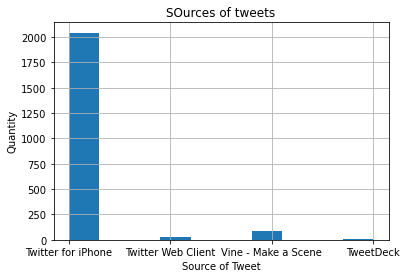

In [246]:
#
tweets_clean.source.hist();
plt.xlabel('Source of Tweet')
plt.ylabel('Quantity')
plt.title('SOurces of tweets')

Twitter for iPhone is the principal source of this tweets